In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sys
from PIL import Image
import PIL
import os
import glob


import matplotlib.pyplot as plt

con2D的厚度大的話gradcam的圖會比較有數字的樣子但是重點呈現不出來

In [188]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=3))
x_test = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=3))
input_shape = (28, 28, 3)
x_train = x_train.numpy()
x_test = x_test.numpy()
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])


# Importing the required Keras modules containing model and layers

# Creating a Sequential Model and adding the layers
model = tf.keras.Sequential(name='quadraticreg')
model.add(layers.Conv2D(25, kernel_size=(3,3),activation='relu', padding='same' ,input_shape=input_shape))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(30, kernel_size=(3,3),activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(layers.Dense(128, activation=tf.nn.relu))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(28, activation=tf.nn.relu))
model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(10,activation=tf.nn.softmax))

scce = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', 
              loss=scce, 
              metrics=['accuracy'])
H = model.fit(x=x_train,y=y_train, epochs=10)

model.evaluate(x_test, y_test)

x_train shape: (60000, 28, 28, 3)
Number of images in x_train 60000
Number of images in x_test 10000
Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4497 - accuracy: 0.8594
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0867 - accuracy: 0.9765
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0575 - accuracy: 0.9840
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0435 - accuracy: 0.9869
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0336 - accuracy: 0.9901
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0255 - accuracy: 0.9931
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0280 - accuracy: 0.9918
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0233 - accuracy: 0.9924
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0192 

[0.052784886211156845, 0.9894000291824341]

In [189]:
model.summary()

Model: "quadraticreg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 25)        700       
_________________________________________________________________
dropout_18 (Dropout)         (None, 28, 28, 25)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 30)        6780      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5880)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               752768    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)              

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer_name,classifier_layer_names裡面的東西要根據上面的summary名子改

In [190]:
import numpy as np
import cv2


last_conv_layer_name = "conv2d_16"
classifier_layer_names = [
    "max_pooling2d_7",
    "flatten_7",
    "dense_21",
    "dropout_19",
    "dense_22",
    "dropout_20",
    "dense_23",
]

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:,top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

0


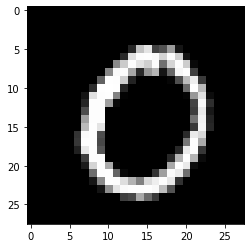

In [192]:
image_index = 101 # You may select anything up to 60,000
plt.imshow(x_test[image_index])
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 3))
print(pred.argmax())

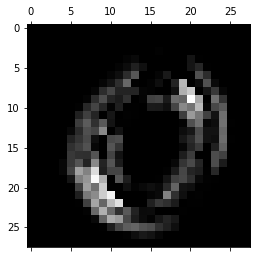

In [193]:
img_array = x_test[image_index].reshape(1, 28, 28, 3)
img_size = (28, 28)
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

img = img_array.reshape(28,28,3)
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
#jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = cv2.resize(jet_heatmap,(img.shape[1], img.shape[0]))
#jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img

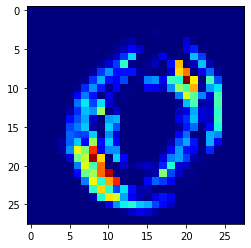

In [194]:
plt.imshow(jet_heatmap)

下面是最後一層con2D厚度為10的情況

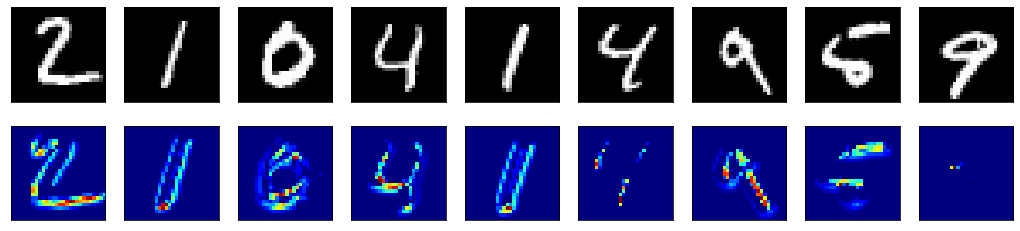

In [187]:
decoded_imgs = model.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstruction
    image_index = i
    img_array = x_test[image_index].reshape(1, 28, 28, 3)
    img_size = (28, 28)
    preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )

# Display heatmap

    img = img_array.reshape(28,28,3)
# We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

# We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
#jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = cv2.resize(jet_heatmap,(img.shape[1], img.shape[0]))
#jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    ax = plt.subplot(2, n, i + n)
    plt.imshow(jet_heatmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

下面是最後一層con2D厚度為30的情況

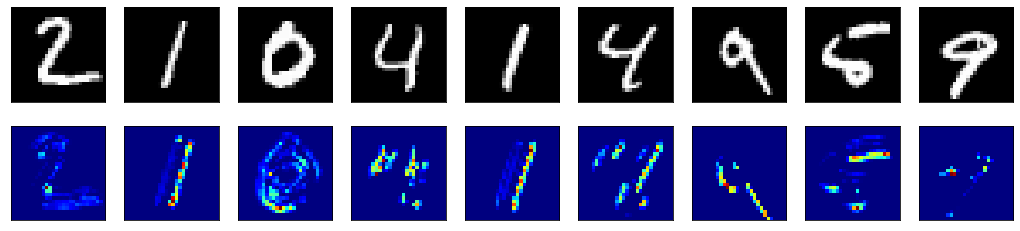

In [191]:
decoded_imgs = model.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstruction
    image_index = i
    img_array = x_test[image_index].reshape(1, 28, 28, 3)
    img_size = (28, 28)
    preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )

# Display heatmap

    img = img_array.reshape(28,28,3)
# We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

# We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
#jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = cv2.resize(jet_heatmap,(img.shape[1], img.shape[0]))
#jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    ax = plt.subplot(2, n, i + n)
    plt.imshow(jet_heatmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()